In [23]:
import networkx as nx
import numpy as np

import input_functions as inp
import tsp_routines
from clustering.funcs import k_cluster
from clustering.funcs import best_dropoff
from input_functions.funcs import create_new_graph

In [7]:
def graph_from_input(filename):
    '''graph_from_input(str) --> nx.graph G, np.ndarray[int] homes, dict locToIndex 
    Returns a graph created by reading the input file, with integer vertex labels
    Returns list of the home indices
    Returns a map from integer to the name associated with that node'''
    with open(filename, 'r') as f:
        G = nx.Graph()
        
        locToIndex = {} # maps location name to its index number
        homes = []
        lines = f.readlines()
        
        numLocations = int(lines[0])
        numTAs = int(lines[1])
        locations = lines[2].split()
    
        i = 0
        assert len(locations) == numLocations, "Number of locations must match specified value"
        for loc in locations:
            G.add_node(i)
            locToIndex[loc] = i
            i += 1
            
        TAhomes = lines[3].split()
        assert len(TAhomes) == numTAs, "Number of TA homes must match specified value"
        for home in TAhomes:
            homes.append(locToIndex[home])
        
        homes.insert(0, locToIndex[lines[4].strip()])
        
        row = 0
        for line in lines[5:]:
            line = line.split()
            for col in range(len(line)):
            
                if line[col] != 'x':  
                    G.add_edge(row, col)
                    weight = float(line[col])
                    G[row][col]['weight'] = weight
            row += 1
            
        indexToLoc = {v: k for k, v in locToIndex.items()}
        return G, homes, indexToLoc

In [3]:
def map_dict_entries(input_dict,nodemapper):
    """
    maps the keys and values of the input dict using the nodemapper dict.
    """
    output_dict = dict()
    for key in input_dict.keys():
        mapped_key = nodemapper[key]
        output_dict.update({mapped_key:[]})
        for vertex in input_dict[key]:
            output_dict[mapped_key].append(nodemapper[vertex])
    return output_dict

def add_vertex_to_clusters(clusters,vertex):
    """
    add the given vertex to each cluster.
    Input:
    clusters - dict where the keys are vertices which are cluster centers and the values are a list of 
                vertices belonging to this cluster
    vertex - the vertex to be added to each list in `clusters`
    """
    for key in clusters:
        clusters[key].append(vertex)
        
def get_dropoff_vertices(clusters):
    best_dropoffs = []
    for key in clusters:
        dropoff = best_dropoff(G,clusters[key])
        best_dropoffs.append(dropoff)
    return best_dropoffs
        
def solve_by_clustering(graph,homes,source,num_clusters):
    """
    return the route to be followed by the car as it drops off TAs.
    Inputs:
    graph - input graph
    homes - list of vertices in `graph` that are marked as homes
    source - vertex in `graph` that is the start and end of the path followed by the car
    num_clusters - the number of clusters to be used to group the homes together
    """
    homes_subgraph = tsp_routines.complete_shortest_path_subgraph(graph,homes)
    home_clusters = k_cluster(homes_subgraph,num_clusters)
    # The source vertex is added to each of the clusters before determining the best dropoff location.
    # This is done so that vertices that are closer to the source are given higher preference as dropoff points.
    add_vertex_to_clusters(home_clusters,source)
    dropoff_vertices = get_dropoff_vertices(home_clusters)
    # Add the source to the dropoff vertices
    dropoff_vertices.append(source)
    # Get rid of any repeating entries in the dropoff vertices
    dropoff_vertices = list(set(dropoff_vertices))
    # Construct the fully connected sub-graph with the dropoff vertices 
    # on which TSP is computed
    dropoff_subgraph = tsp_routines.complete_shortest_path_subgraph(graph,dropoff_vertices)
    tsp_route = tsp_routines.metric_mst_tsp(dropoff_subgraph,source)
    return tsp_route
    

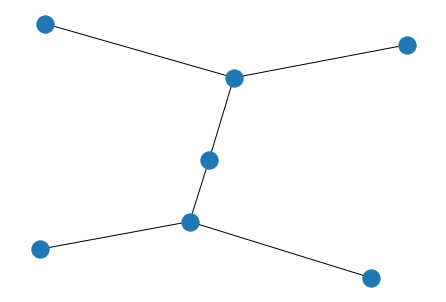

In [6]:
G = nx.Graph()
G.add_edge(1,2,weight=1)
G.add_edge(2,3,weight=2)
G.add_edge(2,4,weight=1)
G.add_edge(1,5,weight=2)
G.add_edge(5,6,weight=1)
G.add_edge(5,7,weight=3)
nx.draw(G)

In [5]:
homes = [3,4,6,7]
tsp_route = solve_by_clustering(G,homes,1,2)
print(tsp_route)

[1, 2, 5, 1]


In [25]:
def check_cost(G, route):
    return np.random.rand()

In [ ]:
def cluster_solver(filename,):
    """returns the best route and its cost, found by decreasing nclusters from nhomes to 2"""
    G, homes, node_to_name_map = graph_from_input(filename)
    k = len(homes) #how many clusters initially
    cost = np.inf
    out_route = []
    for i in range(k-2):
        #assumed that homes[0] is the source
        tsp_route = solve_by_clustering(G,homes,homes[0],k)
        tempcost = check_cost(G, tsp_route)
        if tempcost<cost:
            cost = tempcost
            out_route = tsp_route
        k-=1
    return out_route, cost